In [1]:
import numpy as np

%matplotlib ipympl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

I don't understand why you need to run this command twice to get an interactive matplotlib display

In [2]:
%matplotlib ipympl

In [3]:
import lsst.daf.persistence        as dafPersist
import lsst.afw.display            as afwDisplay

#### Setup the displays (by default an interface to ds9, which won't work in the LSP)

In [4]:
afwDisplay.setDefaultBackend("matplotlib" if True else "firefly")

## Let's look at some data

#### Read the input data

In [5]:
butler = dafPersist.Butler("/datasets/hsc/repo/rerun/RC/w_2019_18/DM-19151")

In [6]:
dataId = dict(tract=9813, patch='3,6', filter='HSC-G')
exposure = butler.get('deepCoadd_calexp', dataId)
sources = butler.get('deepCoadd_forced_src' if False else 'deepCoadd_meas', dataId)

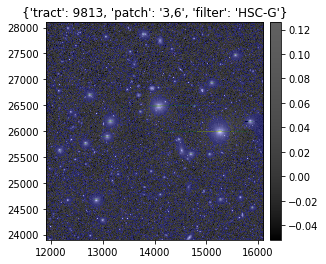

In [7]:
disp = afwDisplay.Display(reopenPlot=True)

for k in ["CLIPPED", "INEXACT_PSF", "BRIGHT_OBJECT", "SENSOR_EDGE", "REJECTED"]:
    disp.setMaskPlaneColor(k, afwDisplay.IGNORE)

disp.scale('asinh', 'zscale', Q=8)
disp.mtv(exposure, title=str(dataId))

#disp.zoom(8, 500, 1500);

Define a boolean array that tells us which objects are 'good'; in this case:
 - No saturated pixels near their centres
 - terminal objects that haven't been further deblended

In [8]:
good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_interpolatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

#### Look at how well the aperture photometry agrees with the PSF measurements

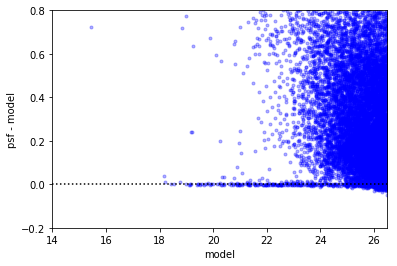

In [9]:
apMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'base_CircularApertureFlux_12_0')
modelMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'modelfit_CModel')
psfMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'slot_PsfFlux')
kronMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'ext_photometryKron_KronFlux')

if False:
    mag1, str1 = apMag, "ap"
elif True:
    mag1, str1 = modelMag, "model"
else:
    mag1, str1 = kronMag, "Kron"
mag2, str2 = psfMag, "psf"

plt.close(1); plt.figure(1)
plt.plot(mag1[good], (mag2 - mag1)[good], '.', alpha=0.3, color='blue')

plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 26.5)
plt.ylim(-0.2, 0.8)

plt.xlabel(str1)
plt.ylabel(f"{str2} - {str1}")

plt.show()

This doesn't look like modern CCD data as there's no brighter-fatter effect.  That's because we corrected it at the pixel level as part of the instrumental signature effect.

## What photometry is available?

In [10]:
for k in sources.getSchema().extract("*_instFlux").keys():
    print(k)
    if "slot" not in k and "Blendedness" not in k:
        print(k)

deblend_psf_instFlux
deblend_psf_instFlux
base_Blendedness_raw_child_instFlux
base_Blendedness_raw_parent_instFlux
base_Blendedness_abs_child_instFlux
base_Blendedness_abs_parent_instFlux
base_SdssShape_instFlux
base_SdssShape_instFlux
base_CircularApertureFlux_3_0_instFlux
base_CircularApertureFlux_3_0_instFlux
base_CircularApertureFlux_4_5_instFlux
base_CircularApertureFlux_4_5_instFlux
base_CircularApertureFlux_6_0_instFlux
base_CircularApertureFlux_6_0_instFlux
base_CircularApertureFlux_9_0_instFlux
base_CircularApertureFlux_9_0_instFlux
base_CircularApertureFlux_12_0_instFlux
base_CircularApertureFlux_12_0_instFlux
slot_ApFlux_instFlux
slot_CalibFlux_instFlux
base_CircularApertureFlux_17_0_instFlux
base_CircularApertureFlux_17_0_instFlux
base_CircularApertureFlux_25_0_instFlux
base_CircularApertureFlux_25_0_instFlux
base_CircularApertureFlux_35_0_instFlux
base_CircularApertureFlux_35_0_instFlux
base_CircularApertureFlux_50_0_instFlux
base_CircularApertureFlux_50_0_instFlux
base_Ci

##### Show the sky objects

These are patches of the image which contain no detected objects, but we make all measurements there anyway

In [11]:
disp.erase()
with disp.Buffering():
    for s in sources[good]:
        if s.get("merge_peak_sky"):
            disp.dot('+', *s.getCentroid(), ctype=afwDisplay.RED)

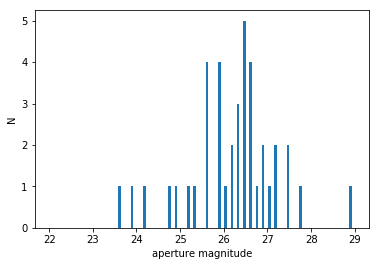

In [14]:
skySources = sources[sources['merge_peak_sky']].copy(True)
apMags = exposure.getPhotoCalib().instFluxToMagnitude(skySources, 'base_CircularApertureFlux_17_0')

plt.close(1); plt.figure(1)
plt.hist(apMags, bins=np.linspace(22, 29, 50))
plt.xlabel("aperture magnitude")
plt.ylabel("N");

### Astropy

In [13]:
sources[good].copy(deep=True).asAstropy()

id,coord_ra,coord_dec,parent,merge_footprint_i2,merge_footprint_i,merge_footprint_r2,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_N921,merge_footprint_N816,merge_footprint_N1010,merge_footprint_N387,merge_footprint_N515,merge_footprint_sky,merge_peak_i2,merge_peak_i,merge_peak_r2,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_N921,merge_peak_N816,merge_peak_N1010,merge_peak_N387,merge_peak_N515,merge_peak_sky,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_InputCount_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_3_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_InputCount_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_0_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_1_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_2_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_3_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,modelfit_DoubleSha